# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
1551,5683,50635,Kuala Lumpur,17-03-2020,Supermarts tell Malaysians to resist panic buy...,Extremely Negative
4076,8756,53708,"Dallas, TX",18-03-2020,We should have that in the US as well.. some p...,Negative
20130,28347,73299,NaN,26-03-2020,Inside the Story of How H-E-B Planned for the ...,Positive
17436,25008,69960,"Ventura, California",25-03-2020,It's hard for everyone to find what they need ...,Extremely Positive


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
df['Sentiment'].unique()

array(['Positive', 'Extremely Negative', 'Negative', 'Extremely Positive'],
      dtype=object)

In [ ]:
df["Sentiment"] = np.where(df["Sentiment"].isin(["Positive", "Extremely Positive"]), 1, 0)

In [ ]:
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
10309,16310,61262,"Scotland, United Kingdom",21-03-2020,I ve not panic bought anything Just doing litt...,1
7360,12733,57685,NaN,20-03-2020,Our research found #PriceGouging on Amazon for...,1
11607,17878,62830,"Mid Yell, Scotland",21-03-2020,"Out of food, had to risk the supermarket, no o...",1
26943,36834,81786,"Arlington, VA",07-04-2020,.@NRECANews seeks federal relief for #electric...,1


Сбалансированы ли классы?

In [ ]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

**Ответ:** Классы достаточно сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [ ]:
df = df.fillna('Unknown')

In [ ]:
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
22279,31014,75966,"Long Island, NY",03-04-2020,The payment data provided by state officials s...,0
7720,13181,58133,New Orleans,20-03-2020,Health Care Workers Grocery Store Employees an...,1
23732,32798,77750,Unknown,05-04-2020,read on UNITElive Supermarket lorry drivers ...,0
14756,21744,66696,Unknown,23-03-2020,ÃÂToilet paper and hand sanitizer aren't the...,1


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
tweets = train['OriginalTweet'].str.lower().str.split()
tweets

25621    [why, we, still, want, to, buy, so, much, stuf...
30135    [with, driving, even, more, usage, a, strong, ...
28899    [@canon_india, i, am, very, happy.., great, jo...
5989     [the, u.s, national, debt, will, likely, excee...
4367     [finally, got, to, the, grocery, store., hones...
                               ...                        
20757    [football, is, in, ruins, right, now.when, it,...
32103    [hand, sanitizer, made, here, on, the, skellig...
30403    [an, initiative, taken, by, our, @goldeninitia...
21243    [vile, premiership, players, demanding, full, ...
2732     [just, wondering, why, we, arenãât, screenin...
Name: OriginalTweet, Length: 23410, dtype: object

In [ ]:
token_counts = {}
for tokens in tweets:
    for token in tokens:
        if token in token_counts:
            token_counts[token] += 1
        else:
            token_counts[token] = 1

Какой размер словаря получился?

In [ ]:
len(token_counts)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [ ]:
from collections import Counter

counter = Counter(token_counts)
top_10_tokens = counter.most_common(10)
for i in range(len(top_10_tokens)):
    token, count = top_10_tokens[i]
    print(f"{i + 1}. {token}: {count}")

1. the: 26815
2. to: 23373
3. and: 14684
4. of: 13012
5. a: 11737
6. in: 11198
7. for: 8566
8. #coronavirus: 8223
9. is: 7383
10. are: 7050


**Ответ:** Потому что предлоги и местоимения чаще всего используются в твиттах

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [ ]:
import nltk
nltk.download("punkt", quiet=True)
nltk.download('stopwords', quiet=True)

True

In [ ]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
token_counts = {token: count for token, count in token_counts.items() if token not in stop_words}

counter = Counter(token_counts)
top_10_tokens = counter.most_common(10)
for i in range(len(top_10_tokens)):
    token, count = top_10_tokens[i]
    print(f"{i + 1}. {token}: {count}")

1. #coronavirus: 8223
2. prices: 3891
3. food: 3820
4. grocery: 3469
5. supermarket: 3288
6. people: 3175
7. covid-19: 3173
8. store: 3155
9. #covid19: 2471
10. &amp;: 2314


**Ответ:** Некоторые темы содержат несколько вхождений из-за отсутствия разделения слов от символов

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [ ]:
bottom_20_tokens = counter.most_common()[-20:]
for i in range(len(bottom_20_tokens)):
    token, count = bottom_20_tokens[i]
    print(f"{i + 1}. {token}: {count}")

1. skellig: 1
2. coast!: 1
3. closer!): 1
4. @skelligsix18: 1
5. #skelligcoast2kms: 1
6. #southkerry: 1
7. https://t.co/zjcl195vqs: 1
8. @srinivasiyc: 1
9. https://t.co/iaek4fwsgz: 1
10. premiership: 1
11. non-playing: 1
12. subsidise: 1
13. playersãâ: 1
14. renewing: 1
15. wage!: 1
16. flew: 1
17. nothing...: 1
18. @torontopearson: 1
19. @680news: 1
20. https://t.co/7j2y3rsld9: 1


**Ответ:** Потому что эти токены содержат символы, а комбинация определенного слова + символа встречается намного реже. Нужно отделить слова от символов



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [ ]:
from nltk.tokenize import TweetTokenizer

tw = TweetTokenizer()
tweets = train['OriginalTweet'].apply(lambda x: tw.tokenize(x))
token_counts = {}

for tokens in tweets:
  for token in tokens:
        if token in token_counts:
            token_counts[token] += 1
        else:
            token_counts[token] = 1

counter = Counter(token_counts)
top_10_tokens = counter.most_common(10)
for i in range(len(top_10_tokens)):
    token, count = top_10_tokens[i]
    print(f"{i + 1}. {token}: {count}")

1. the: 24337
2. .: 24118
3. to: 22933
4. ,: 17571
5. and: 14354
6. of: 12904
7. a: 11045
8. in: 10573
9. ?: 9524
10. for: 8228


**Ответ:** В нем есть знаки препинания. Потому что предыдущий токенайзер их не выделял

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [ ]:
from string import punctuation

token_counts = {token: count for token, count in token_counts.items() if
                token not in stop_words and token not in punctuation}

counter = Counter(token_counts)
top_10_tokens = counter.most_common(10)
for i in range(len(top_10_tokens)):
    token, count = top_10_tokens[i]
    print(f"{i + 1}. {token}: {count}")

1. Â: 7415
2. : 7311
3. 19: 7167
4. #coronavirus: 7143
5. I: 5235
6. : 4372
7. prices: 4281
8. COVID: 4218
9. food: 3795
10. store: 3691


**Ответ:** Иноязычные буквы и смайлики

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [ ]:
token_counts = {token: count for token, count in token_counts.items() if
                len(token) > 1 or (len(token) == 1 and ord(token[0]) < 128)}

counter = Counter(token_counts)
top_10_tokens = counter.most_common(10)
for i in range(len(top_10_tokens)):
    token, count = top_10_tokens[i]
    print(f"{i + 1}. {token}: {count}")

1. 19: 7167
2. #coronavirus: 7143
3. I: 5235
4. prices: 4281
5. COVID: 4218
6. food: 3795
7. store: 3691
8. supermarket: 3373
9. grocery: 3083
10. people: 3047


**Ответ:** Лучше - нет повторений из-за использования разных символов с одним словом

Хуже - названия, которые используются вместе с символами (covid-19) делятся на 2 токена

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [ ]:
tweets_with_hashtags = tweets.apply(lambda x: [token for token in x if token.startswith("#")])

token_counts = {}
for tokens in tweets_with_hashtags:
  for token in tokens:
        if token in token_counts:
            token_counts[token] += 1
        else:
            token_counts[token] = 1

counter = Counter(token_counts)
top_10_tokens = counter.most_common(10)
for i in range(len(top_10_tokens)):
    token, count = top_10_tokens[i]
    print(f"{i + 1}. {token}: {count}")

1. #coronavirus: 7143
2. #COVID19: 1844
3. #Covid_19: 1463
4. #Coronavirus: 1281
5. #COVID2019: 927
6. #toiletpaper: 657
7. #covid19: 568
8. #COVID: 542
9. #CoronaCrisis: 426
10. #CoronaVirus: 351


**Ответ:** все про коронавирус

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [ ]:
tweets_with_links = tweets.apply(lambda x: [token for token in x if token.startswith("https://t.co")])

token_counts = {}
for tokens in tweets_with_links:
  for token in tokens:
        if token in token_counts:
            token_counts[token] += 1
        else:
            token_counts[token] = 1

counter = Counter(token_counts)
top_10_tokens = counter.most_common(10)
for i in range(len(top_10_tokens)):
    token, count = top_10_tokens[i]
    print(f"{i + 1}. {token}: {count}")

1. https://t.co/oXA7SWtoNd: 5
2. https://t.co/gP3EusapL8: 4
3. https://t.co/DefTruI1PfÃÂ: 3
4. https://t.co/WrLHYzIzAA: 3
5. https://t.co/kuwIpF1KQW: 3
6. https://t.co/zjNRx6dKKN: 3
7. https://t.co/3GBBDpdjat: 3
8. https://t.co/e2ZNXajPre: 3
9. https://t.co/CATKegAyOY: 3
10. https://t.co/G63RP042HO: 3


**Ответ:** Не сравнима. Наверное нет, по ссылке мало что можно сказать

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):

  text = text.lower()
  tokens = tw.tokenize(text)
  tokens = [token for token in tokens if token not in stop_words
            and token not in punctuation
            and (len(token) != 1 or (len(token) == 1 and ord(token[0]) < 128))
            and not token.startswith("https://t.co")]

  return tokens

In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(tokenizer=custom_tokenizer)
X = cv.fit_transform(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** Размер меньше

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [ ]:
text = [train.iloc[ind]['OriginalTweet']]
tweet = cv.transform(text)
tweet_array = tweet.toarray()
non_zero_cols = np.any(tweet_array, axis=0)

pd.DataFrame(tweet_array[:, non_zero_cols], columns=cv.get_feature_names_out()[non_zero_cols])

,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


**Ответ:** Нет, так как в тексте нет токена, встречающегося несколько раз

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(tokenizer=custom_tokenizer)
X = tv.fit_transform(train['OriginalTweet'])
tweet = tv.transform(text)
tweet_array = tweet.toarray()
non_zero_cols = np.any(tweet_array, axis=0)

pd.DataFrame(tweet_array[:, non_zero_cols], columns=tv.get_feature_names_out()[non_zero_cols])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,#coronavirusoutbreak,#covid2019,@skynews,brainless,ffs,food,france,lets,nice,one,panic,ppl,queueing,show
0,0.225843,0.168252,0.310426,0.386764,0.324474,0.113289,0.320473,0.301211,0.254273,0.163067,0.147595,0.255006,0.354346,0.244065


**Ответ:** Да, так как веса рассчитываются по встречаемости не только в данном твитте, но и во всех остальных

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'good' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
21541,30079,75031,Unknown,02-04-2020,"To all my marketers friends, this is a very go...",1
20314,28576,73528,"New Delhi, India",27-03-2020,India on lockdown...I'm more worried by death ...,1
192,4035,48987,"San Diego, CA",16-03-2020,"What's a good way to support grocery store, me...",1
5140,10048,55000,New Zealand,19-03-2020,Countdown supermarket limiting some goods: You...,1
19139,27090,72042,Unknown,25-03-2020,@MorganRadford good segment! BTW where did yo...,1
...,...,...,...,...,...,...
19361,27366,72318,Unknown,26-03-2020,@jichiemin LetÃÂs hope it not #coronavirus ?...,1
6250,11382,56334,"Mumbai, India",19-03-2020,Respected Sir @narendramodi \r\r\n\r\r\nWe und...,1
15997,23260,68212,sales@esmmagazine.com,24-03-2020,#Consumer goods giant @Unilever Plc said on Tu...,1
18819,26706,71658,"Chicago, IL",25-03-2020,Online grocery shopping? Here are some good ti...,1


In [ ]:
text = [df.iloc[20314]['OriginalTweet']]
X = tv.fit_transform(text)
pd.DataFrame(X.toarray(), columns=tv.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,#coronavirus,...,amidst,crap,death,distancing,fill,good,hiking,hunger,...,india,lockdown,pandemic,prices,sickness,social,sounds,stomach,vegetable,worried
0,0.185695,0.557086,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,...,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695


**Ответ:** Троеточие выделено, как самый важный токен, так как чаще остальных токенов присутствует в тексте

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [ ]:
cv = CountVectorizer(tokenizer=custom_tokenizer)
bow = cv.fit_transform(train['OriginalTweet'])
bow_test = cv.transform(test['OriginalTweet'])

tv = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf = tv.fit_transform(train['OriginalTweet'])
tfidf_test = tv.transform(test['OriginalTweet'])

y_train = train['Sentiment']
y_test = test['Sentiment']

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [ ]:
# Bag of words

clf = LogisticRegression(random_state=0)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(f'Test accuracy: {accuracy_score(y_test, pred)}')
pred_train = clf.predict(bow)
print(f'Train accuracy: {accuracy_score(y_train, pred_train)}')

Test accuracy: 0.8674506677297189
Train accuracy: 0.9844510892780863


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4552
           1       0.87      0.88      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



In [ ]:
# TF-IDF

clf = LogisticRegression(random_state=0)
clf.fit(tfidf, y_train)
pred = clf.predict(tfidf_test)
print(f'Test accuracy: {accuracy_score(y_test, pred)}')
pred_train = clf.predict(tfidf)
print(f'Train accuracy: {accuracy_score(y_train, pred_train)}')

Test accuracy: 0.8533984452860275
Train accuracy: 0.9254592054677488


In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      4552
           1       0.85      0.88      0.87      5482

    accuracy                           0.85     10034
   macro avg       0.85      0.85      0.85     10034
weighted avg       0.85      0.85      0.85     10034



**Ответ:** CountVectorizer оказался немного лучше чем TF-IDF, однако больше переобучился. Модели показывают очень хорошую точность на тестовой выборке

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [ ]:
from nltk.stem.snowball import SnowballStemmer

In [ ]:
def custom_stem_tokenizer(text):

  stemmer = SnowballStemmer(language='english')

  text = text.lower()
  tokens = tw.tokenize(text)
  tokens = [stemmer.stem(token) for token in tokens if token not in stop_words
            and token not in punctuation
            and (len(token) != 1 or (len(token) == 1 and ord(token[0]) < 128))
            and not token.startswith("https://t.co")]

  return tokens

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
bow = cv.fit_transform(train['OriginalTweet'])
bow_test = cv.transform(test['OriginalTweet'])

tv = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfidf = tv.fit_transform(train['OriginalTweet'])
tfidf_test = tv.transform(test['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652


**Ответ:** Размер уменьшился

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [ ]:
# Bag of words

clf = LogisticRegression(random_state=0)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(f'Test accuracy: {accuracy_score(y_test, pred)}')
pred_train = clf.predict(bow)
print(f'Train accuracy: {accuracy_score(y_train, pred_train)}')

Test accuracy: 0.8674506677297189
Train accuracy: 0.9717642033319095


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



In [ ]:
# TF-IDF

clf = LogisticRegression(random_state=0)
clf.fit(tfidf, y_train)
pred = clf.predict(tfidf_test)
print(f'Test accuracy: {accuracy_score(y_test, pred)}')
pred_train = clf.predict(tfidf)
print(f'Train accuracy: {accuracy_score(y_train, pred_train)}')

Test accuracy: 0.8560892963922663
Train accuracy: 0.9158906450234943


In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4552
           1       0.85      0.89      0.87      5482

    accuracy                           0.86     10034
   macro avg       0.86      0.85      0.85     10034
weighted avg       0.86      0.86      0.86     10034



**Ответ:** Качество модели почти не изменилось. Стемминг имеет смысл применять, так как уменьшается размер словаря, что делает модель более простой. Также должна увеличиваться полнота, поскольку захватывается больше однокоренных слов

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7000
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


In [ ]:
bow = cv_df.fit_transform(train['OriginalTweet'])
bow_test = cv_df.transform(test['OriginalTweet'])

clf = LogisticRegression(random_state=0)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer).fit(train['OriginalTweet'])

tokens = cv_df.get_feature_names_out()

bow = cv_df.fit_transform(train['OriginalTweet']).toarray()
sums = np.sum(bow, axis=0)
most_frequent = np.argmax(sums)

tokens[most_frequent]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


'#coronavirus'

**Ответ:** Параметр получился большой, потому что самый популярный токен (#coronavirus) встречался очень много раз в тексте

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3700


In [ ]:
bow = cv_df.fit_transform(train['OriginalTweet'])
bow_test = cv_df.transform(test['OriginalTweet'])

clf = LogisticRegression(random_state=0)
clf.fit(bow, y_train)
pred = clf.predict(bow_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Ответ:** При удалении непопулярных токенов качество модели почти не изменилось

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4552
           1       0.87      0.89      0.88      5482

    accuracy                           0.87     10034
   macro avg       0.87      0.87      0.87     10034
weighted avg       0.87      0.87      0.87     10034



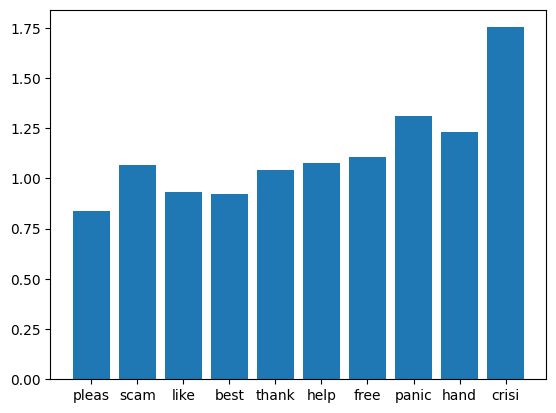

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=False)
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

clf = LogisticRegression(max_iter=1000, random_state=0)
clf.fit(bow, y_train)
print(classification_report(y_test, pred))

tokens = cv_df.get_feature_names_out()
weights = np.abs(clf.coef_.flatten())
top_10_indices = np.argpartition(weights, -10)[-10:]
top_10_tokens = tokens[top_10_indices]
top_10_weights = weights[top_10_indices]
plt.bar(top_10_tokens, top_10_weights)
plt.show()

**Ответ:** Токены содержатся в словах, имеющих сильную эмоциональную окраску

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [ ]:
df[['UserName', 'ScreenName']].duplicated().any()

False

**Ответ:** Признаки неполезны, так как значения пользователей уникальны, а значит нельзя выявить по ним какие-либо закономерности. Например, склонны ли какие-либо пользователи к негативным или позитивным твиттам

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

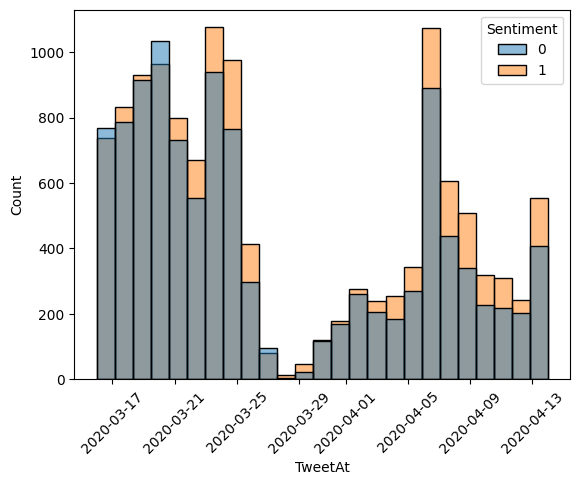

In [ ]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], dayfirst=True)

sns.histplot(train, x='TweetAt', hue='Sentiment')
plt.xticks(rotation=45)
plt.show()

**Ответ:** Возможно этот признак полезен для определения дней, когда преобладают твитты определенной эмоциональной окраски

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
train['Location'].value_counts().size

7949

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

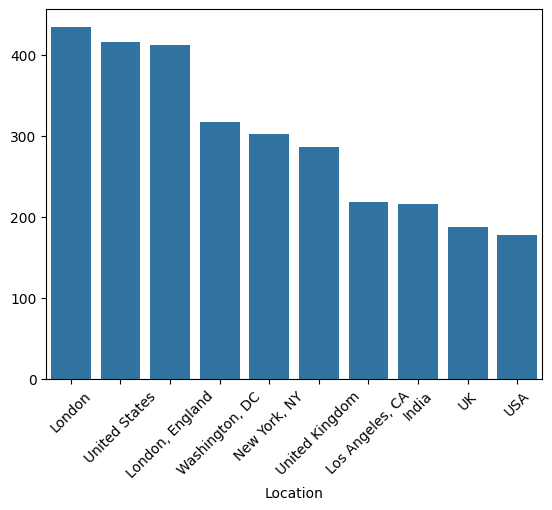

In [ ]:
top_10_locations = df['Location'][df['Location'] != 'Unknown'].value_counts().head(10)

sns.barplot(x=top_10_locations.index, y=top_10_locations.values)
plt.xticks(rotation=45)
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

Unique categories: 6117


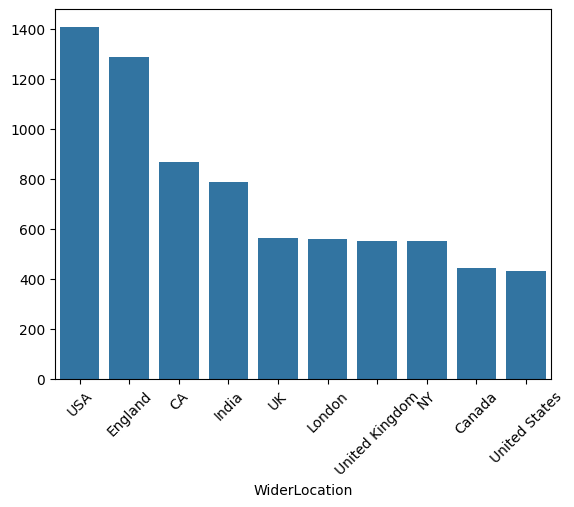

In [ ]:
df['WiderLocation'] = df['Location'][df['Location'] != 'Unknown'].str.split(',').str.get(-1).str.strip()
print(f'Unique categories: {df["WiderLocation"].value_counts().size}')

top_10_locations = df['WiderLocation'].value_counts().head(10)

sns.barplot(x=top_10_locations.index, y=top_10_locations.values)
plt.xticks(rotation=45)
plt.show()

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
# value counts
locations = df['WiderLocation'].value_counts()
# more than 1
freq_locations = locations[locations > 1].index
# encode
WiderLocation = enc.fit_transform(np.array(freq_locations).reshape(-1, 1))

WiderLocation.size

1307

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [ ]:
# Split WiderLocation for training
train['WiderLocation'], test['WiderLocation'] = train_test_split(df['WiderLocation'], random_state=0, test_size=0.3)

# Encode Location
enc = OneHotEncoder(handle_unknown='ignore', categories=[freq_locations])
WiderLocation_train = enc.fit_transform(train[['WiderLocation']])
WiderLocation_test = enc.transform(test[['WiderLocation']])

# Location feature names
locations = enc.get_feature_names_out()

# Convert new attributes to dataframe
WiderLocation_train = pd.DataFrame(WiderLocation_train.toarray(), columns=locations)
WiderLocation_test = pd.DataFrame(WiderLocation_test.toarray(), columns=locations)
BetterText_train = pd.DataFrame(bow.toarray(), columns=tokens)
BetterText_test = pd.DataFrame(bow_test.toarray(), columns=tokens)

# Concat new attributes
train_data = pd.concat([BetterText_train, WiderLocation_train], axis=1)
test_data = pd.concat([BetterText_test, WiderLocation_test], axis=1)

# LogReg
clf = LogisticRegression(max_iter=1000, random_state=0)
clf.fit(train_data, y_train)
y_pred = clf.predict(test_data)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4552
           1       0.85      0.86      0.86      5482

    accuracy                           0.84     10034
   macro avg       0.84      0.84      0.84     10034
weighted avg       0.84      0.84      0.84     10034



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4552
           1       0.85      0.86      0.86      5482

    accuracy                           0.84     10034
   macro avg       0.84      0.84      0.84     10034
weighted avg       0.84      0.84      0.84     10034



**Ответ:** Качество ухудшилось. Возможно из-за того, что по местоположению пользователя сложно выявить явные закономерности для определения эмоциональной окраски твитта. Признак оказался неполезным

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
4,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive


Prep Location data

In [ ]:
# Remove singular values

value_counts = df['Location'].value_counts()
freq_locations = value_counts[value_counts > 1].index
df['Location'] = df['Location'][df['Location'].isin(freq_locations)]

In [ ]:
# Simplify location data
df['WiderLocation'] = np.where(df['Location'].str.contains(','), df['Location'].str.split(',').str[-1].str.strip(), df['Location'])

In [ ]:
f"Missing location values: {round(df['WiderLocation'].isna().mean() * 100)}%"

'Missing location values: 45%'

In [ ]:
# Fill NaN values with random
locations = df['WiderLocation'].apply(lambda location: np.random.choice(df['WiderLocation'].dropna()) if pd.isna(location) else location)

In [ ]:
f"Missing location values: {round(locations.isna().mean() * 100)}%"

'Missing location values: 0%'

In [ ]:
locations = locations.rename('Location')

In [ ]:
enc = OneHotEncoder()
encoded_locations = enc.fit_transform(pd.DataFrame(locations))

In [ ]:
enc = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
encoded_locations = enc.fit_transform(pd.DataFrame(locations))
encoded_locations

,Location_,Location_ ? ??? ?t ?? l???? ?t ??,Location_ ??,Location_ England,Location_ Ginninderra Creek Canberra Oz,Location_ India,Location_ USA,Location_#Africa,Location_#BayArea #SouthBay Bureau,Location_#LeafNation #MagicFairyStyle,...,Location_venus,Location_wales,Location_world,Location_worldwide,Location_y'all,Location_yo mama,Location_||somali|kenyan??,Location_Â¯\_(?)_/Â¯,Location_Ãwu lakoda!!,Location_Ãsterreich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33439,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Prep Tweet data

In [ ]:
# Tokenizer

tw = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
stemmer = SnowballStemmer('english')

def tokenize(text):
  # lowercase
  text = text.lower()
  # tweet tokenize
  tokens = tw.tokenize(text)
  # stopwords
  tokens = [token for token in tokens if token.lower() not in stop_words]
  # punctuation
  tokens = [token for token in tokens if token not in punctuation]
  # single chars
  tokens = [token for token in tokens if len(token) != 1]
  # links
  tokens = [token for token in tokens if not token.startswith("https://t.co")]
  # stem
  tokens = [stemmer.stem(token) for token in tokens]

  return tokens

def custom_stem_tokenizer(text):

  stemmer = SnowballStemmer(language='english')

  text = text.lower()
  tokens = tw.tokenize(text)
  tokens = [stemmer.stem(token) for token in tokens if token not in stop_words
            and token not in punctuation
            and (len(token) != 1 or (len(token) == 1 and ord(token[0]) < 128))
            and not token.startswith("https://t.co")]

  return tokens

In [ ]:
# Tokenize
tweets = df['OriginalTweet'].apply(lambda tweet: tokenize(tweet))

In [ ]:
tweets = tweets.rename('Tweet')

In [ ]:
print(tweets)
encoded_locations.toarray()

0        [advic, talk, neighbour, famili, exchang, phon...
1        [coronavirus, australia, woolworth, give, elde...
2        [food, stock, one, empti, ..., pleas, panic, e...
3        [readi, go, supermarket, #covid19, outbreak, i...
4        [news, regionâ, first, confirm, covid, 19, cas...
                               ...                        
33439    [never, weâ, situat, world, go, supermarket, p...
33440    [definit, man, feel, like, fall, need, honor, ...
33441    [respons, complaint, provid, cite, covid, 19, ...
33442    [know, itâ, get, tough, ration, toilet, paper,...
33443    [well, new, use, rift, go, 700.00, amazon, rn,...
Name: Tweet, Length: 33444, dtype: object


AttributeError: 'DataFrame' object has no attribute 'toarray'

Work with modified data

In [ ]:
encoded_locations


In [ ]:
#Scaler
scaler = StandardScaler(with_mean=False)
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

In [ ]:
# Concat locations and tweets
X = pd.concat([tweets, encoded_locations], axis=1)
y = df['Sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state=0)

In [ ]:
X_train['Tweet']

In [ ]:
# Vectorize

vec = TfidfVectorizer(ngram_range=(1, 3))
tfidf = vec.fit_transform([' '.join(tokens) for tokens in X_train['Tweet']])
tfidf_test = vec.transform([' '.join(tokens) for tokens in X_test['Tweet']])

In [ ]:
pd.concat([pd.DataFrame(tfidf.toarray()), X_train.drop('Tweet', axis=1)])

In [ ]:
pd.concat([X_train['Location'], X_test['Location']])

In [ ]:
enc = OneHotEncoder(sparse_output=False).set_output(transform='pandas')
X_train['Location'] = enc.fit_transform(pd.DataFrame(pd.concat([X_train['Location'], X_test['Location']])))
X_train['Location']

In [ ]:
tfidf.toarray()

In [ ]:
# LogReg
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)